# 5: Problems with Machine Learning on Graphs
Dive deeper into:
-  Predicting missing links in a graph
-  Detecting meaningful structures such as communities
-  Detecting graph similarities and graph matching

## Link Prediction
Predict if or if not there is an edge between two nodes when this status is unknown, here we have $E = E_o \cup E_u$ where $E_o$ are the observed links and edges $E_u$ are unknown links. For Link Prediction, we wish to exploit $E_o$ to estimate $E_u$. This is common in temporal graph systems where we want to estimate t+1; also is used widely in domains such as recommender systems or find hidden connections within networks. We have two families of approaches:
-  Similarity-based
-  Embedding-based

### Similarity-based Methods
Estimate a similarity function between each couple of nodes in a graph. Divide into sub-families:
-  **Index-based**: Simple calculation of index based on neighboursof a given couple of nodes. Based on calculation of a simple index from information obtained by analysing the neighbours of two disconnected nodes...
    -  Resource allocation index: Sum of 1/(Num neighbours for v nodes)



In [1]:
import networkx as nx
edges = [[1,3], [2,3], [2,4], [4,5], [5,6], [5,7]]
G = nx.from_edgelist(edges)
preds = nx.resource_allocation_index(G, [(1,2), (2,5), (3,4)]) # second arg is a list of possible edges

In [3]:
list(preds) # p. of each edge is 0.5

[(1, 2, 0.5), (2, 5, 0.5), (3, 4, 0.5)]

**Jaccard Coefficient**: Neighbours of nodes u and v; intersection over union

In [4]:
preds = nx.jaccard_coefficient(G, [(1,2), (2,5), (3,4)]) 
list(preds)

[(1, 2, 0.5), (2, 5, 0.25), (3, 4, 0.3333333333333333)]

There are other methods too such as *adamic_adar_index* and *preferential_attachment*.

-  **Community-based**: Index computed using information about community to which a given couple of nodes belong first


Community Common Neighbour: Computes number of common neighbours and adds this to number of common neighbours belonging to same community.

[(1, 2, 2), (2, 5, 1), (3, 4, 1)]


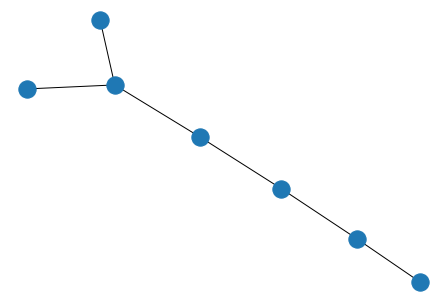

In [7]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

# assign community property
G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1

preds = nx.cn_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds)) # output not in range (0,1)
nx.draw(G)

Community resource allocation: Merges information obtained from neighbours of nodes with community. Algorithm where we take sum of nodes and allocate 1 if belongs to same community, 0 otherwise and normalise by neighbours of node v

[(1, 2, 0.5), (2, 5, 0), (3, 4, 0)]


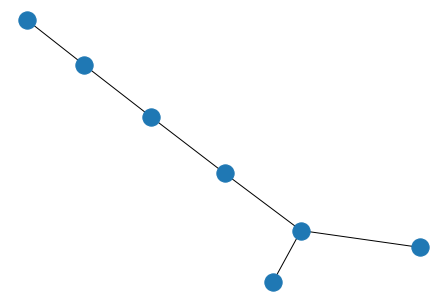

In [9]:
import networkx as nx
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)

G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1
preds = nx.ra_index_soundarajan_hopcroft(G,[(1,2),(2,5),(3,4)])
print(list(preds))
nx.draw(G) # nodes in same community have a higher value in index

Now we can look at more complex techniques based on ML; and edge embedding to perform prediction of unknown edges.

### Embedding-based Mehods
Here we approach link prediction as supervised classification. For a given graph, each couple of nodes is represented as a feature vector, and class label assigned to node couples. The whole process can be summarised into two main steps:
1.  For each node of the graph G, its embedding vector is computed using a node2vec algorithm
2.  For all the possible couple of nodes in the graph, the embedding is computed using edge2vec

So we have a generic ML algorithm to generate feature vectors to solve classification problem.

In [11]:
import networkx as nx
import pandas as pd

edgelist = pd.read_csv("cora.cites", sep='\t', header=None, names=["target", "source"])
G = nx.from_pandas_edgelist(edgelist)
#nx.draw_graph(G)

FileNotFoundError: [Errno 2] No such file or directory: 'cora.cites'

In [ ]:
from stellargraph.data import EdgeSplitter

# stellargraph to split datasaet
# will have positive and negative instances
edgeSplitter = EdgeSplitter(G)
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

In [ ]:
edgeSplitter = EdgeSplitter(graph_test, G)
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

In [ ]:
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder 

# generate embedding of each couple of nodes in training set
node2vec = Node2Vec(graph_train)
model = node2vec.fit()
# hadamard to generate embedding of each couple of nodes in training set
# values used as feature vectors for training of model
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

In [ ]:
# embeddings may change between runs?
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# train with RF classifier
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_embeddings, labels_train);

In [ ]:
from sklearn import metrics

y_pred = rf.predict(test_embeddings)

print('Precision:', metrics.precision_score(labels_test, y_pred))
print('Recall:', metrics.recall_score(labels_test, y_pred))
print('F1-Score:', metrics.f1_score(labels_test, y_pred))

## Detecting Meaningful Structures such as Communities